In [17]:
import pandas as pd
import zipfile
import os
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

In [18]:
zip_path = r"D:\桌面\ml-100k.zip"
extract_folder = r"D:\桌面\ml-100k"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

ratings_file = os.path.join(extract_folder, 'ml-100k', 'u.data')
movies_file = os.path.join(extract_folder, 'ml-100k', 'u.item')

In [19]:
genres = [
    "Unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
    "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",
    "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

In [21]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_file, sep='\t', header=None, names=columns)

# Load movie genres
item_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{i}' for i in range(19)]
movies = pd.read_csv(movies_file, sep='|', names=item_cols, encoding='latin-1')

In [24]:
utility_matrix = ratings.pivot_table(index='user_id', columns='item_id', values='rating')
print("Utility Matrix:")
print(utility_matrix.head()) 

Utility Matrix:
item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2         4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  ...   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5         4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

item_id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user_id                                                              
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5         NaN   NaN   NaN   NaN

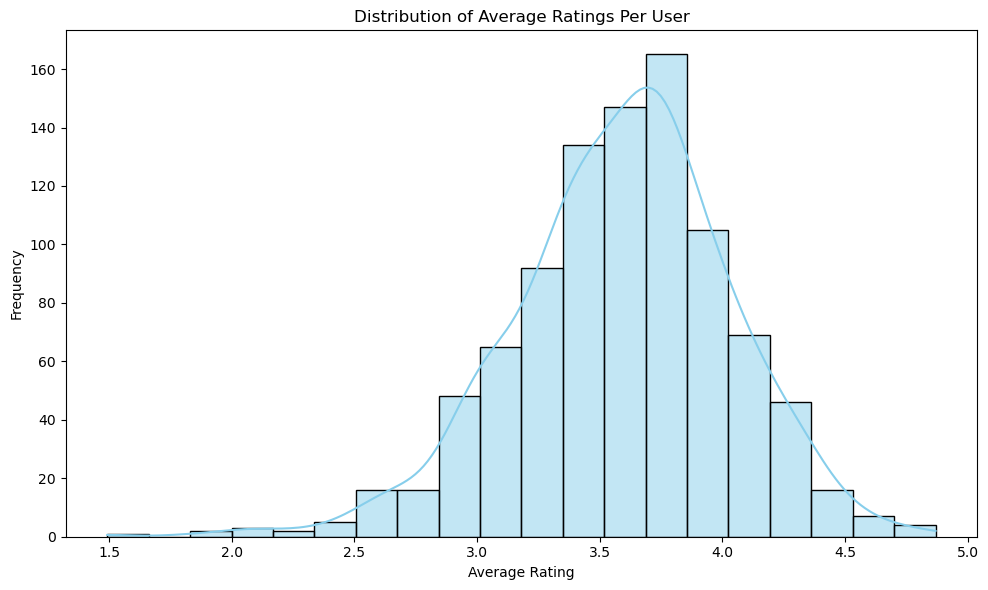

In [26]:
plt.figure(figsize=(10, 6))
user_avg_ratings = ratings.groupby('user_id')['rating'].mean()
sns.histplot(user_avg_ratings, kde=True, color="skyblue", bins=20)
plt.title('Distribution of Average Ratings Per User')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(r"D:/桌面/数据挖掘/Average_Ratings_Per_User_Distribution.png")
plt.show()

In [27]:
user_means = utility_matrix.mean(axis=1)
user_centered = utility_matrix.subtract(user_means, axis=0)
print("\nUser-centered Ratings (first 5 rows):")
print(user_centered.head()) 


User-centered Ratings (first 5 rows):
item_id      1         2         3         4         5         6         7     \
user_id                                                                         
1        1.389706 -0.610294  0.389706 -0.610294 -0.610294  1.389706  0.389706   
2        0.290323       NaN       NaN       NaN       NaN       NaN       NaN   
3             NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4             NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5        1.125714  0.125714       NaN       NaN       NaN       NaN       NaN   

item_id      8         9         10    ...  1673  1674  1675  1676  1677  \
user_id                                ...                                 
1       -2.610294  1.389706 -0.610294  ...   NaN   NaN   NaN   NaN   NaN   
2             NaN       NaN -1.709677  ...   NaN   NaN   NaN   NaN   NaN   
3             NaN       NaN       NaN  ...   NaN   NaN   NaN   NaN   NaN   
4            

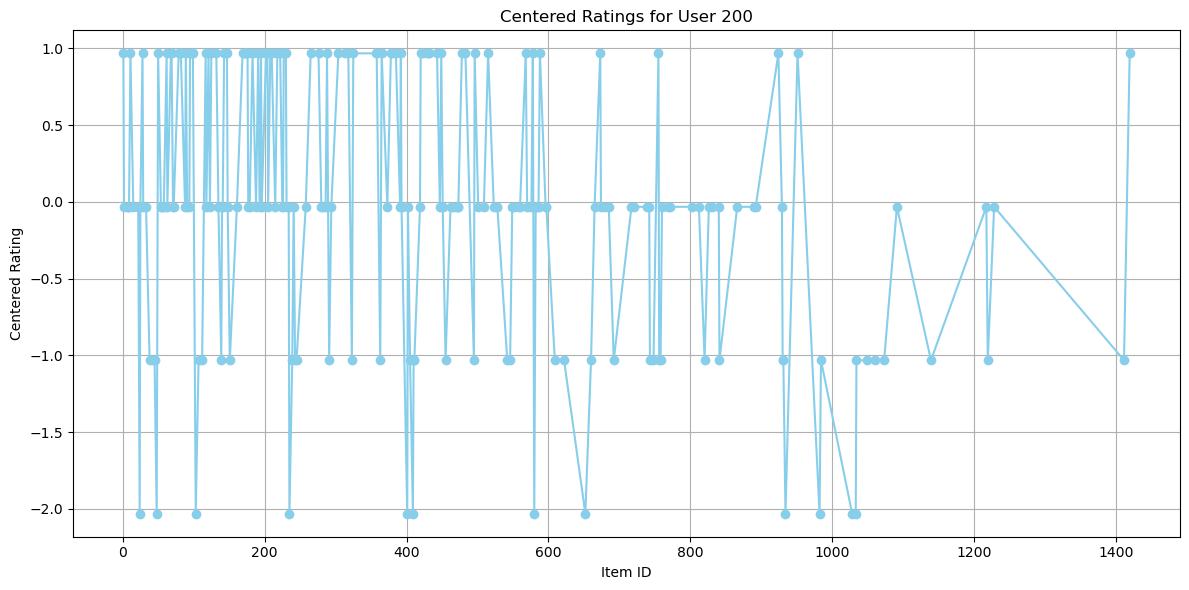

In [53]:
plt.figure(figsize=(12, 6))
user_200_ratings = user_centered.loc[200].dropna()
plt.plot(user_200_ratings.index, user_200_ratings.values, marker='o', color='skyblue', label='User 200 Centered Ratings')
plt.title('Centered Ratings for User 200')
plt.xlabel('Item ID')
plt.ylabel('Centered Rating')
plt.grid(True)
plt.tight_layout()
plt.savefig(r"D:/桌面/数据挖掘/Centered_Ratings_User_200.png")
plt.show()

In [29]:
movie_genres = movies.set_index('movie_id')[[f'genre_{i}' for i in range(19)]]
print("\nMovie genres (first 5 movies):")
print(movie_genres.head())


Movie genres (first 5 movies):
          genre_0  genre_1  genre_2  genre_3  genre_4  genre_5  genre_6  \
movie_id                                                                  
1               0        0        0        1        1        1        0   
2               0        1        1        0        0        0        0   
3               0        0        0        0        0        0        0   
4               0        1        0        0        0        1        0   
5               0        0        0        0        0        0        1   

          genre_7  genre_8  genre_9  genre_10  genre_11  genre_12  genre_13  \
movie_id                                                                      
1               0        0        0         0         0         0         0   
2               0        0        0         0         0         0         0   
3               0        0        0         0         0         0         0   
4               0        1        0         0  

In [30]:
def build_user_profile(user_id, user_centered, movie_genres):
    user_ratings = user_centered.loc[user_id].dropna()
    rated_items = user_ratings.index
    if len(rated_items) == 0:
        return np.zeros(19).reshape(1, -1)
    profile = np.zeros(19)
    for item_id, rating in user_ratings.items():
        if item_id in movie_genres.index:
            profile += rating * movie_genres.loc[item_id].values
    norm = np.linalg.norm(profile)
    if norm == 0:
        return np.zeros(19).reshape(1, -1)
    profile /= norm
    return profile.reshape(1, -1)

In [31]:
profile_200_vec = build_user_profile(200, user_centered, movie_genres)
profile_15_vec = build_user_profile(15, user_centered, movie_genres)
print("\nUser 200 Profile Vector:")
print(profile_200_vec)  

print("\nUser 15 Profile Vector:")
print(profile_15_vec)


User 200 Profile Vector:
[[ 0.          0.47166287  0.18083389  0.05199177 -0.11795634 -0.58555735
  -0.11665654 -0.07132621  0.17628461  0.02372125  0.06791425  0.12900459
   0.12104335 -0.03964373  0.09943427  0.5126064  -0.02177156  0.1561378
  -0.00454928]]

User 15 Profile Vector:
[[ 0.         -0.15282327  0.05393762 -0.13484406 -0.25620371 -0.19777129
  -0.08090644  0.          0.53937623  0.04944282  0.0089896  -0.13484406
  -0.06292723 -0.11237005  0.50791262 -0.08989604 -0.4629646   0.18878168
   0.        ]]


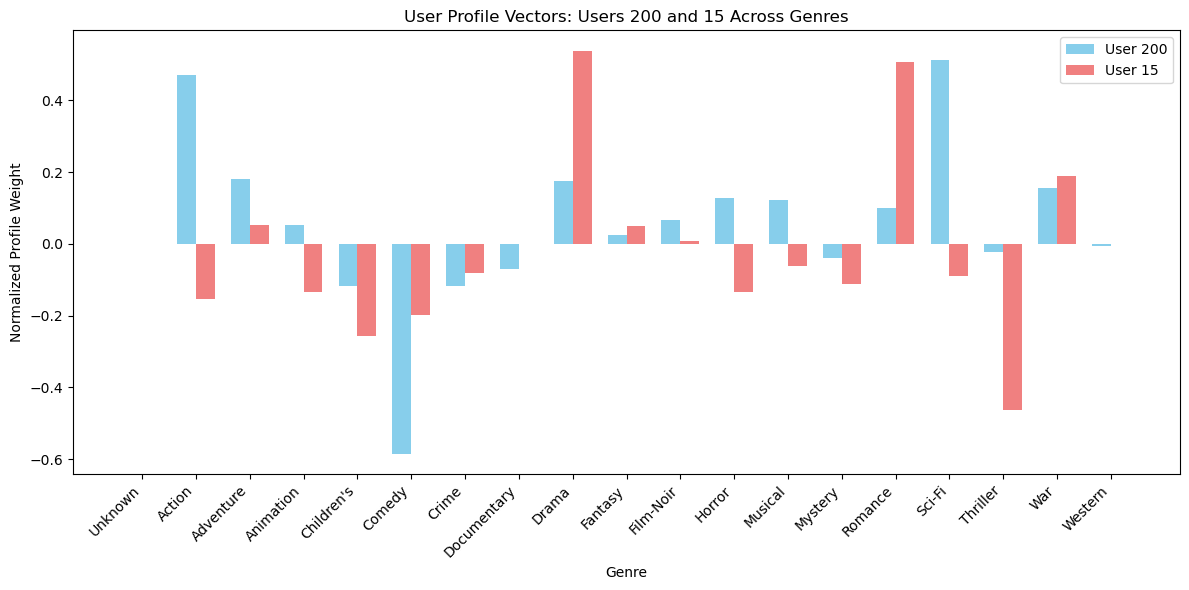

In [32]:
plt.figure(figsize=(12, 6))
x = np.arange(len(genres))
width = 0.35
plt.bar(x - width/2, profile_200_vec[0], width, label='User 200', color='skyblue')
plt.bar(x + width/2, profile_15_vec[0], width, label='User 15', color='lightcoral')
plt.xticks(x, genres, rotation=45, ha='right')
plt.title('User Profile Vectors: Users 200 and 15 Across Genres')
plt.ylabel('Normalized Profile Weight')
plt.xlabel('Genre')
plt.legend()
plt.tight_layout()
plt.savefig(r'D:/桌面/数据挖掘/User_Profiles_200_15.png')
plt.show()

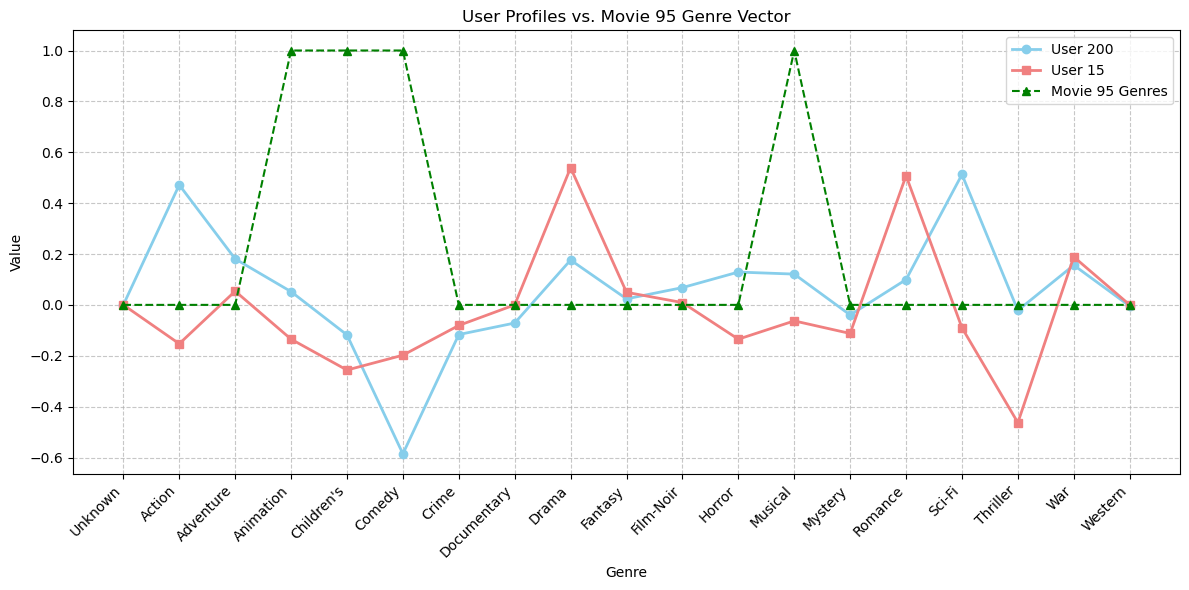

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(genres, profile_200_vec[0], marker='o', label='User 200', color='skyblue', linewidth=2)
plt.plot(genres, profile_15_vec[0], marker='s', label='User 15', color='lightcoral', linewidth=2)
plt.plot(genres, item_95_vec[0], marker='^', label='Movie 95 Genres', color='green', linestyle='--', linewidth=1.5)
plt.xticks(rotation=45, ha='right')
plt.title('User Profiles vs. Movie 95 Genre Vector')
plt.ylabel('Value')
plt.xlabel('Genre')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(r'D:/桌面/数据挖掘/User_Profiles_vs_Movie_95.png')
plt.show()

In [40]:
item_95_vec = movie_genres.loc[95].values.reshape(1, -1)
print("\nMovie 95 Genre Vector:")
print(item_95_vec)


Movie 95 Genre Vector:
[[0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0]]


In [41]:
sim_200_95 = cosine_similarity(profile_200_vec, item_95_vec)[0, 0]
sim_15_95 = cosine_similarity(profile_15_vec, item_95_vec)[0, 0]
dist_200_95 = 1 - sim_200_95
dist_15_95 = 1 - sim_15_95

In [42]:
print(f"User 200 and item 95 cosine similarity: {sim_200_95:.4f}")
print(f"User 200 and item 95 cosine distance: {dist_200_95:.4f}")
print(f"User 15 and item 95 cosine similarity: {sim_15_95:.4f}")
print(f"User 15 and item 95 cosine distance: {dist_15_95:.4f}")

User 200 and item 95 cosine similarity: -0.2652
User 200 and item 95 cosine distance: 1.2652
User 15 and item 95 cosine similarity: -0.3259
User 15 and item 95 cosine distance: 1.3259


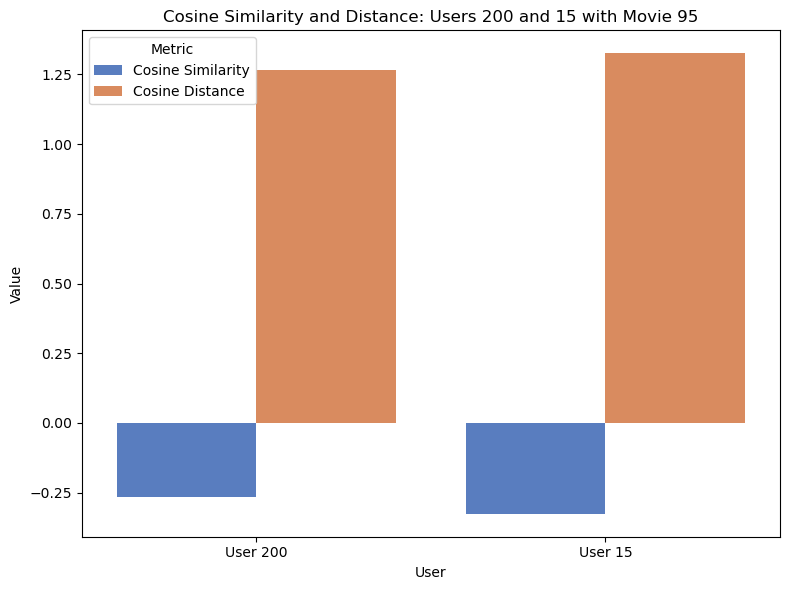

In [43]:
plt.figure(figsize=(8, 6))
data = {
    'Metric': ['Cosine Similarity', 'Cosine Similarity', 'Cosine Distance', 'Cosine Distance'],
    'User': ['User 200', 'User 15', 'User 200', 'User 15'],
    'Value': [sim_200_95, sim_15_95, dist_200_95, dist_15_95]
}
df_metrics = pd.DataFrame(data)
sns.barplot(x='User', y='Value', hue='Metric', data=df_metrics, palette='muted')
plt.title('Cosine Similarity and Distance: Users 200 and 15 with Movie 95')
plt.ylabel('Value')
plt.xlabel('User')
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig(r'D:/桌面/数据挖掘/Cosine_Similarity_Distance_Users_200_15.png')
plt.show()

In [44]:
if sim_200_95 > sim_15_95:
    print("Recommend movie 95 to user 200.")
elif sim_15_95 > sim_200_95:
    print("Recommend movie 95 to user 15.")
else:
    print("Both users have equal similarity to movie 95.")

Recommend movie 95 to user 200.
